In [1]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font='SimHei')
plt.rcParams['axes.grid'] = False

from IPython.display import SVG

def show_image(filename, figsize=None):
    if figsize:
        plt.figure(figsize=figsize)

    plt.imshow(plt.imread(filename))

TreeBoost原理和实现（sklearn）简介
===========================

### 前言

TreeBoost是对GBDT做了更深一步的优化，主要贡献在将整颗树的全局权重值细化到每片叶子的局部权重值。它不像xgboost在树生长时就做出指导，而是在树生长后再修正叶子值。对于工程中的GBDT模块，spark目前是传统的Gradient Boosting，而sklearn采用了TreeBoost，所以本文以sklearn为例进行说明。

本文假设读者已经了解GBDT的基本原理。

sklearn代码版本：

```sh
~/W/s/sklearn ❯❯❯ git log -n 1
commit d161bfaa1a42da75f4940464f7f1c524ef53484f
Author: John B Nelson <jnelso11@gmu.edu>
Date:   Thu May 26 18:36:37 2016 -0400

    Add missing double quote (#6831)
```

GBDT模块位于`sklearn/ensemble/gradient_boosting.py`文件，类的关系比较简单。

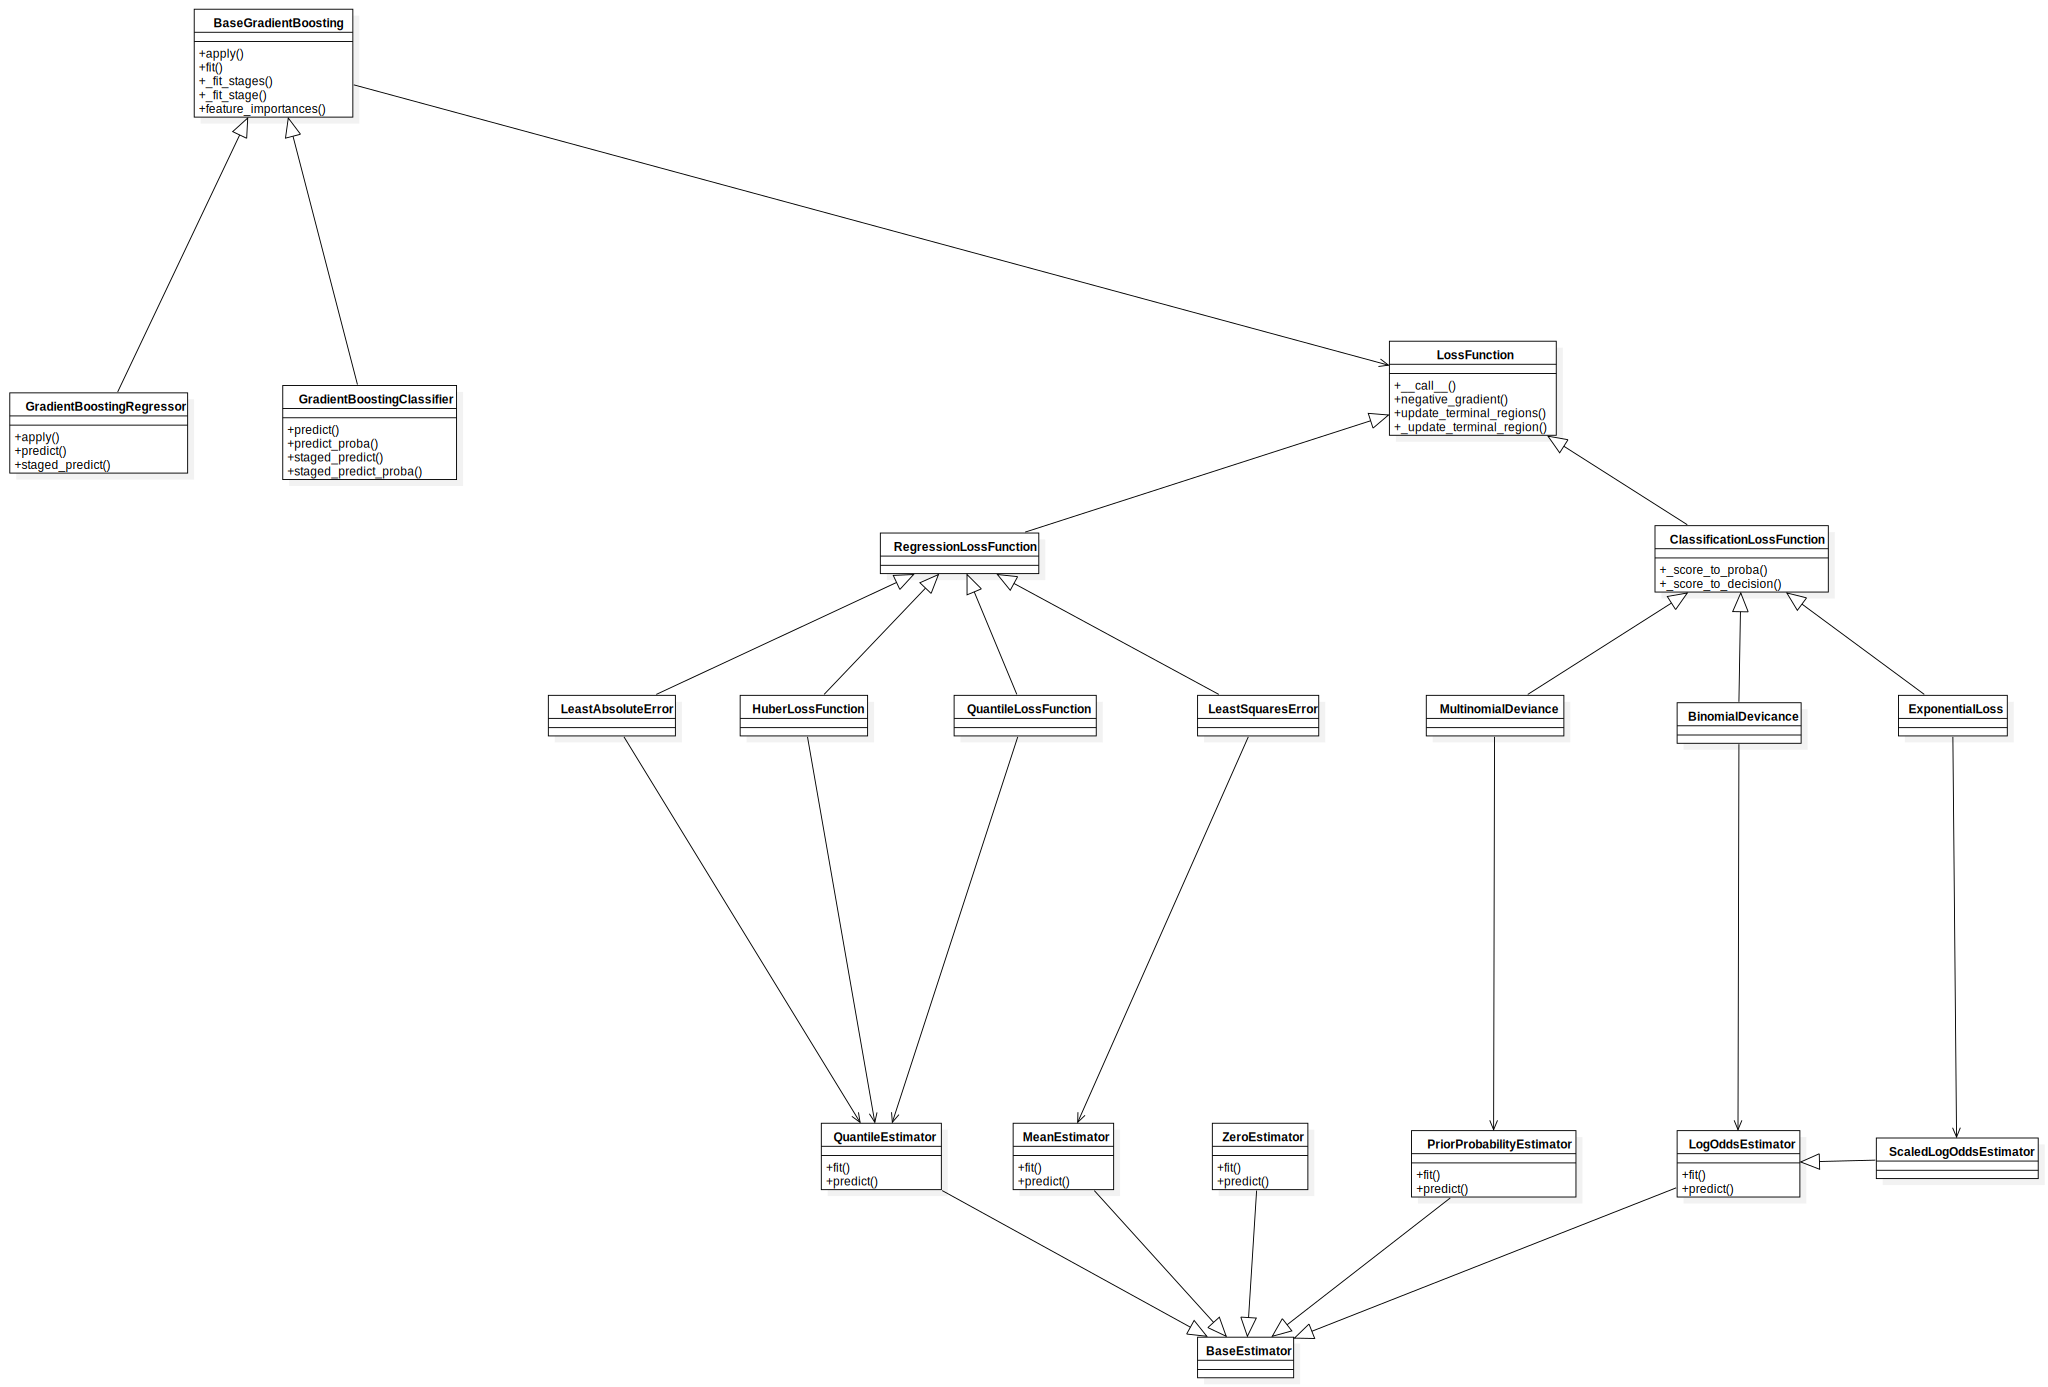

In [3]:
SVG("./res/Main.svg")

### GBDT优化

传统的Gradient Boost算法主要有四步：

1. 对损失导数求偏导；
2. 训练决策树，拟合偏导；
3. 寻优模型权值；
4. 将训练的模型，加到叠加模型中。

可以用数学公式对应表述为[1]：

+ $F_0(x) = \operatorname{arg \, min}_\rho \displaystyle \sum_{i=1}^N L(y_i, \rho)$

+ For $m=1$ to $M$ do:
   
   1. $\tilde{y} = - \left [ \frac{\partial L (y_i, F(x_i))}{\partial F(x_i)} \right ]_{F(x) = F_{m-1}(x)}, \quad i = 1, 2, \dotsc, N$
   
   2. $\mathbf{a}_m = \operatorname{arg \, min}_{\mathbf{a}, \beta} \displaystyle \sum_{i=1}^N \left [ \tilde{y}_i - \beta h(x_i; \mathbf{a}) \right ]^2$
   3. $\rho_m = \operatorname{arg \, min}_\rho \displaystyle \sum_{i=1}^N L \left ( y_i, F_{m-1}(x_i) + \rho h(x_i; \mathbf{a}_m) \right)$
   4. $F_m(x) = F_{m-1}(x) + l_r \rho_m h(x; \mathbf{a}_m)$
   
其中，$L$是损失函数， $l_r$是学习率，$\rho$是模型的权值，$h(x_i; \mathbf{a})$是决策树模型，$\mathbf{a}$是树的参数，$F$是最终累加模型。
   
利用一些数学方法和损失函数的特性，可以将第3步的权值寻优进行简化。在sklear中单步训练代码对应如下：

```Python
 748     def _fit_stage(self, i, X, y, y_pred, sample_weight, sample_mask,
 749                    random_state, X_idx_sorted, X_csc=None, X_csr=None):
 750         """Fit another stage of ``n_classes_`` trees to the boosting model. """
 751 #+--  8 lines: assert sample_mask.dtype == np.bool----------
 759
 760             residual = loss.negative_gradient(y, y_pred, k=k,
 761                                               sample_weight=sample_weight)
 762
 763             # induce regression tree on residuals
 764             tree = DecisionTreeRegressor(
 765                 criterion='friedman_mse',
 766                 splitter='best',
 767 #+---  7 lines: max_depth=self.max_depth,------------------
 774                 presort=self.presort)
 775
 776 #+---  8 lines: if self.subsample < 1.0:------------------
 784                 tree.fit(X, residual, sample_weight=sample_weight,
 785                          check_input=False, X_idx_sorted=X_idx_sorted)
 786
 787             # update tree leaves
 788 #+--  5 lines: if X_csr is not None:---------------------
 793                 loss.update_terminal_regions(tree.tree_, X, y, residual, y_pred,
 794                                              sample_weight, sample_mask,
 795                                              self.learning_rate, k=k)
 796
 797             # add tree to ensemble
 798             self.estimators_[i, k] = tree
 799
 800         return y_pred
```

其中，

+ 760L是求解偏导。
+ 784L是生成决策树。注意，对于MSE，$\beta=1$。765L树的评价函数是friedman_mse，它是MSE的变种。我猜测$\beta$是一致的，后续有时间再深究。
+ 793L是TreeBoost做的改进，将第3步寻优全局解$\rho$转化到树内部，后面主要内容就在这。
+ 798L是加回到累加模型。


接下来，我们先就平方差和绝对值两种损失函数，对传统Gradient Boost方法进行第3步的优化，为后续TreeBoost铺路。
   
[1]:  Friedman - Greedy function approximation: A gradient boosting machine

#### Least squares regression

这种损失函数定义是 $L(y, F) = \frac{1}{2} (y - F)^2$，则其导数为$\frac{\partial L}{\partial F} = -(y - F)$。将偏导代入到第1步有：

\begin{align}
    \tilde{y} &= - \left [ \frac{\partial L (y_i, F(x_i))}{\partial F(x_i)} \right ]_{F(x) = F_{m-1}(x)} \\
    &= y_i - F_{m-1}(x_i), \quad i = 1, 2, \dotsc, N \\
\end{align}

将$L$和$\tilde{y}$代入到第3步中，整理可得：

\begin{align}
    \rho_m &= \operatorname{arg \, min}_\rho \displaystyle \sum_{i=1}^N L \left ( y_i, F_{m-1}(x_i) + \rho h(x_i; \mathbf{a}_m) \right) \\
    &= \operatorname{arg \, min}_\rho \displaystyle \sum_{i=1}^N \frac{1}{2} \left ( y_i - F_{m-1}(x_i) - \rho h(x_i; \mathbf{a}_m) \right)^2 \\
    &= \operatorname{arg \, min}_\rho \displaystyle \sum_{i=1}^N \frac{1}{2} \left ( \tilde{y}_i - \rho h(x_i; \mathbf{a}_m) \right)^2 \\
    &= \operatorname{arg \, min}_\rho \displaystyle \sum_{i=1}^N \left ( \tilde{y}_i - \rho h(x_i; \mathbf{a}_m) \right)^2 \\
    &= \operatorname{arg \, min}_\beta \displaystyle \sum_{i=1}^N \left ( \tilde{y}_i - \beta h(x_i; \mathbf{a}_m) \right)^2 \quad \text{符号替换}\\
    &= \beta_m
\end{align}

也就是说，对于平方差这种损失函数，它的最优权值就是第2步中指导决策树生成时的$\beta$值。

这个算法称为LS_Boost，具体过程为：

+ $F_0(x) = \bar{y}$

+ For $m=1$ to $M$ do:
  1. $\tilde{y}_i = y_i - F_{m-1}(x_i), \quad i=1, N$
  2. $(\rho_m, \mathbf{a}_m) = \operatorname{arg \, min}_{\mathbf{a}, \rho} \displaystyle \sum_{i=1}^N \left [ \tilde{y}_i - \rho h(x_i; \mathbf{a}) \right ]^2$
  3. $F_m(x) = F_{m-1}(x) + l_r \rho_m h(x; \mathbf{a}_m)$
  
sklearn中代码如下：
  
```Python
 274 class LeastSquaresError(RegressionLossFunction):
 275     """Loss function for least squares (LS) estimation.
 276     Terminal regions need not to be updated for least squares. """
 277     def init_estimator(self):
 278         return MeanEstimator()
 279
 280     def __call__(self, y, pred, sample_weight=None):
 281         if sample_weight is None:
 282             return np.mean((y - pred.ravel()) ** 2.0)
 283         else:
 284             return (1.0 / sample_weight.sum() *
 285                     np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
 286
 287     def negative_gradient(self, y, pred, **kargs):
 288         return y - pred.ravel()
 289
 290     def update_terminal_regions(self, tree, X, y, residual, y_pred,
 291                                 sample_weight, sample_mask,
 292                                 learning_rate=1.0, k=0):
 293         """Least squares does not need to update terminal regions.
 294
 295         But it has to update the predictions.
 296         """
 297         # update predictions
 298         y_pred[:, k] += learning_rate * tree.predict(X).ravel()
 299
 300     def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
 301                                 residual, pred, sample_weight):
 302         pass
```

前面说过sklearn中$\beta=1$，则$l_r \times \beta = l_r$，所以`update_terminal_regions`这里直接用学习率和树预测值相乘。

#### Least-absolute-deviation (LAD) regression

### 从GBDT到TreeBoost